In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#export
from exp.nb_03Magda import *
from exp.nb_04Magda_corrected import *
from exp.nb_05bMagda import *
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

In [4]:
train_x, train_y, valid_x, valid_y, test_x, test_y = get_mnist()

In [5]:
#export
def norm_all(tr, val, tst):
    tr, val, tst = map(lambda x: normalize(tr, x), (tr, val, tst))
    return tr, val, tst

In [6]:
train_x, valid_x, test_x = norm_all(train_x, valid_x, test_x)

In [7]:
mnist_bunch = DataBunch(train_x, train_y, valid_x, valid_y, 5000)

## Test learner

In [8]:
cb_list = [LossCallback(), AccuracyCallback()]
cb_list.append(ParamScheduler('lr', 'fixed_sched', 0.5))
learner = Learner(mnist_bunch, cb_list)

In [9]:
learner.fit(10)

train:  1.292689323425293 validation:  1.449432373046875
train:  1.1692966222763062 validation:  1.0090575218200684
train:  0.5967571139335632 validation:  0.5476352572441101
train:  0.39348816871643066 validation:  0.37754279375076294
train:  0.37523743510246277 validation:  0.32547152042388916
train:  0.31835106015205383 validation:  0.2810766100883484
train:  0.26043379306793213 validation:  0.2446419894695282
train:  0.27818697690963745 validation:  0.2575910687446594
train:  0.23087453842163086 validation:  0.2280489206314087
train:  0.24081963300704956 validation:  0.2264995127916336
Final accuracy: 0.935000


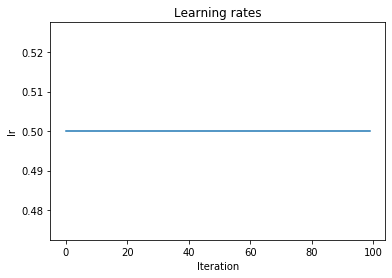

In [10]:
learner.plot_lr()

## ConvNet

In [11]:
#export
class ReshapeMnist(Callback):
    def train_batch_begin(self, *args):
        self.learner.batch_x = self.learner.batch_x.view(-1, 1, 28, 28)

    def validation_batch_begin(self, *args):
        self.train_batch_begin()
        

In [12]:
#export
class Flatten(nn.Module):       
    def forward(self, x):
        return x.view(x.shape[0], -1)
    

In [13]:
#export
class LearnerCnn(Learner):   
    def _get_model(self, num_out=10):
        self.model = nn.Sequential(
            nn.Conv2d(1, 8, 5, padding=2, stride=2), nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1, stride=2), nn.ReLU(),            
            nn.Conv2d(16, 32, 3, padding=1, stride=2), nn.ReLU(),            
            nn.Conv2d(32, 64, 3, padding=1, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            Flatten(),
            nn.Linear(64, num_out)
        )


In [14]:
cb_list = [ReshapeMnist()]
cb_list.append(CombineScheduler('lr', [0.3, 0.7], ['cosine_sched', 'cosine_sched'], 0.3, 0.8, 0.3))
learner_cnn = LearnerCnn(mnist_bunch, cb_list)

In [15]:
%time learner_cnn.fit(3)

CPU times: user 50.8 s, sys: 25.4 s, total: 1min 16s
Wall time: 7.2 s


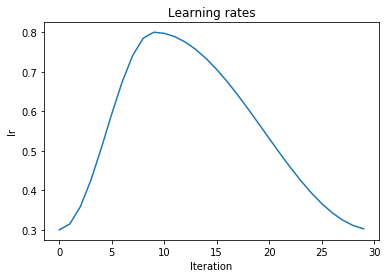

In [16]:
learner_cnn.plot_lr()

## cuda

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [18]:
#export
class CudaCallback(Callback):
    def __init__(self, device):
        self.device = device
        super(CudaCallback, self).__init__()
    
    def fit_begin(self, *args):
        self.learner.model = self.learner.model.to(device=self.device)
    
    def train_batch_begin(self, *args):
        self.learner.batch_x = self.learner.batch_x.to(device=self.device)
        self.learner.batch_y = self.learner.batch_y.to(device=self.device)

    def validation_batch_begin(self, *args):
        self.train_batch_begin()


In [22]:
cb_list = [CudaCallback(device), ReshapeMnist(), LossCallback(), AccuracyCallback()]
cb_list.append(CombineScheduler('lr', [0.3, 0.7], ['cosine_sched', 'cosine_sched'], 0.01, 1, 0.01))
learner_cnn = LearnerCnn(mnist_bunch, cb_list)

In [23]:
%time learner_cnn.fit(10)

train:  2.303323745727539 validation:  2.302888870239258
train:  2.296865224838257 validation:  2.2962357997894287
train:  2.237903118133545 validation:  2.1876606941223145
train:  2.309356927871704 validation:  2.304713487625122
train:  2.272059440612793 validation:  2.2434816360473633
train:  2.306182384490967 validation:  2.299791097640991
train:  2.190755605697632 validation:  2.1586427688598633
train:  1.8482831716537476 validation:  1.809433937072754
train:  1.431034803390503 validation:  1.4136449098587036
train:  1.3546347618103027 validation:  1.3301780223846436
Final accuracy: 0.527200
CPU times: user 12.5 s, sys: 29.9 ms, total: 12.6 s
Wall time: 10.5 s


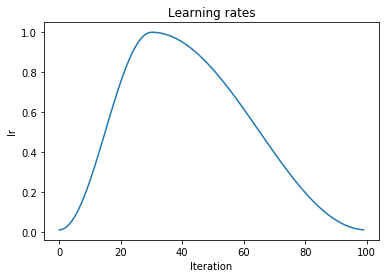

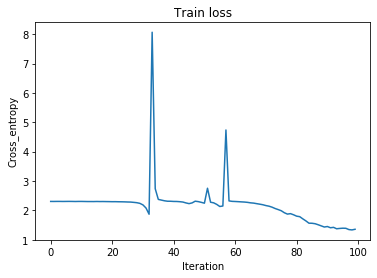

In [24]:
learner_cnn.plot_lr()
learner_cnn.plot_train_loss()

In [2]:
!./notebook2script.py 06Magda_convnet.ipynb

Converted 06Magda_convnet.ipynb to exp/nb_06Magda.py
